<html> <h1 style="font-style:bold; color:blue;"> Neural Computing and Deep Learning </h1> </html>

<html> <h1 style="font-style:italic; color:blue;"> Week-12 </h1> </html>

<html> <h2 style="font-style:italic; color:blue;"> Attention Networks </21> </html>

The tutorial will cover the following:

* Preparing a simple dataset for time series forecasting
* How to use a network built via SimpleRNN for time series forecasting
* Adding a custom attention layer to the SimpleRNN network

_________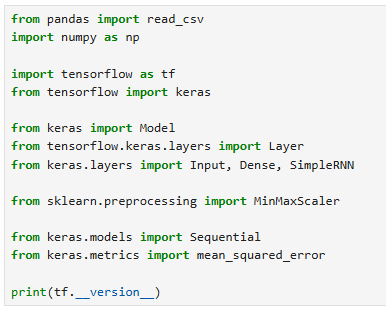

In [1]:
from pandas import read_csv
import numpy as np

import tensorflow as tf
from tensorflow import keras

from keras import Model
from tensorflow.keras. layers import Layer
from keras. layers import Input, Dense, SimpleRNN

from sklearn. preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.metrics import mean_squared_error

print(tf.__version__)

2.18.0


### The Dataset

We will create a fibonacci sequence dataset for our purpose. In Fibonacci sequence, one number is constructed from the previous two numbers. The first 10 numbers of the sequence are shown below:

0, 1, 1, 2, 3, 5, 8, 13, 21, 34, …


When given the previous ‘t’ numbers, can you get a machine to accurately reconstruct the next number? This would mean discarding all the previous inputs except the last two and performing the correct operation on the last two numbers.

For this tutorial, you’ll construct the training examples from t time steps and use the value at t+1 as the target. For example, if t=3, then the training examples and the corresponding target values would look as follows:


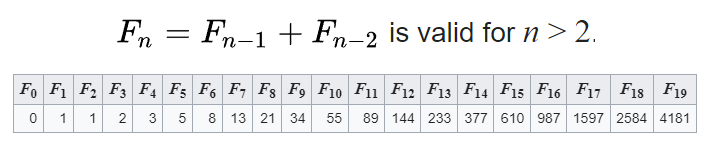

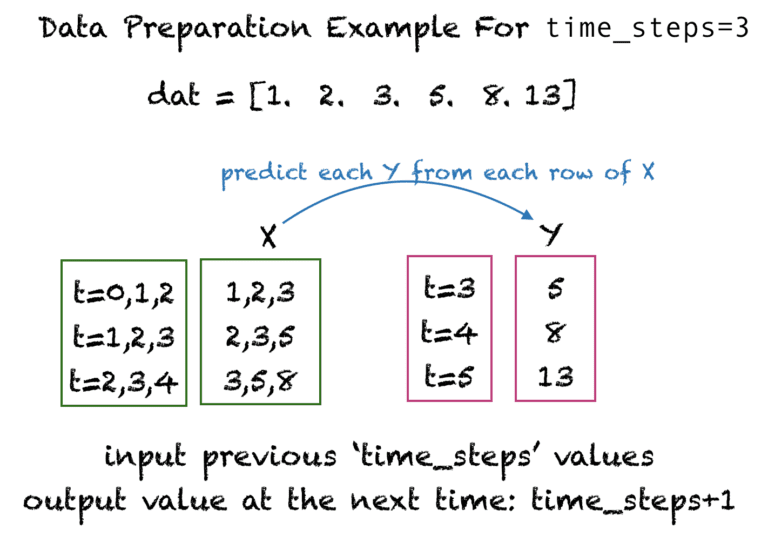

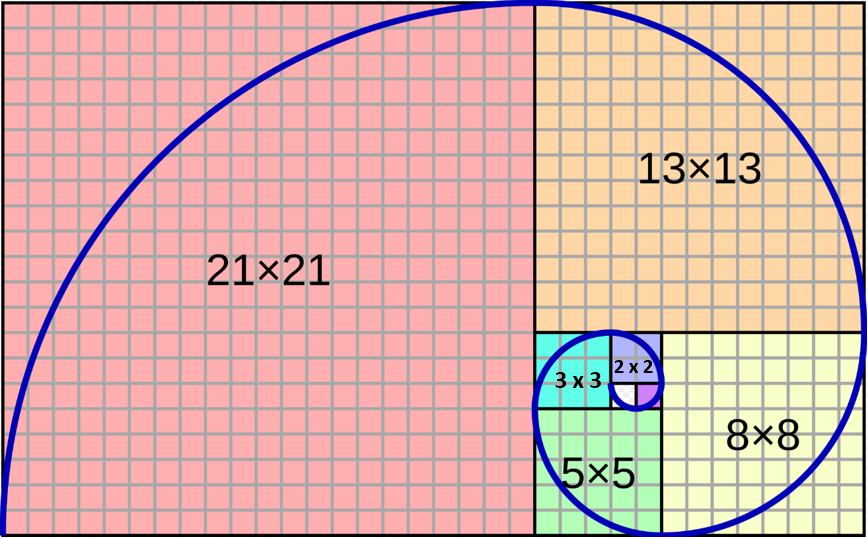

The Fibonacci spiral: an approximation of the **golden spiral** created by drawing circular arcs connecting the opposite corners of squares in the Fibonacci tiling

### Data preprocessing

_____________________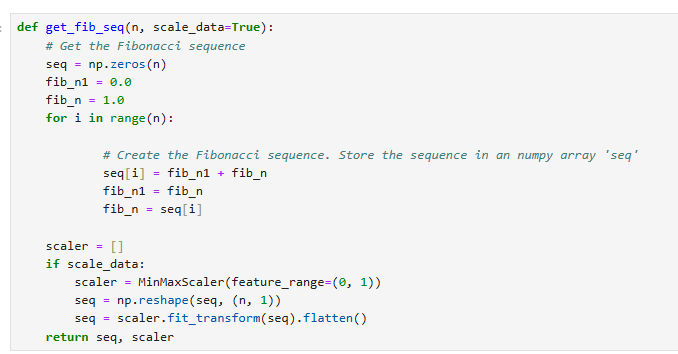

In [2]:
def get_fib_seq(n, scale_data=True) :

    seq = np.zeros(n)
    fib_n1 = 0.0
    fib_n = 1.0
    for i in range(n):
    
        seq[i] = fib_n1 + fib_n
        fib_n1 = fib_n
        fib_n = seq[i]
        
    scaler = []
    if scale_data:
        scaler = MinMaxScaler(feature_range=(0, 1))
        seq = np.reshape(seq, (n, 1))
        seq = scaler. fit_transform(seq) .flatten()
    return seq, scaler

#### Hint:

You can copy blocks of code in the cells above and cells from previous weeks of practice sessions.

Some are easy enough to copy, some need to be slightly modified. This can speed up your code creation.

In [3]:
# Check if the function works correctly:
# Copy the previous cell, change the function name and add fib_n 

________________________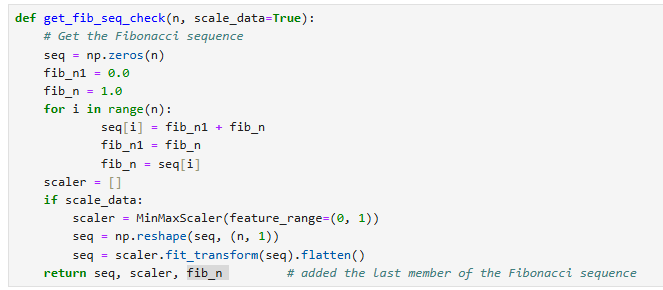

In [4]:
def get_fib_seq_check(n, scale_data=True) :

    seq = np.zeros(n)
    fib_n1 = 0.0
    fib_n = 1.0
    for i in range(n):
        seq[i] = fib_n1 + fib_n
        fib_n1 = fib_n
        fib_n = seq[i]
    scaler = []
    if scale_data:
        scaler = MinMaxScaler(feature_range=(0, 1))
        seq = np.reshape(seq, (n, 1))
        seq = scaler.fit_transform(seq).flatten()
    return seq, scaler, fib_n

_________________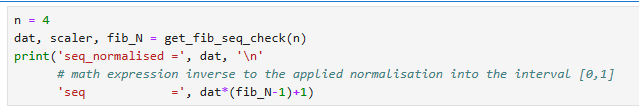

In [5]:
n = 4
dat, scaler, fib_N = get_fib_seq_check(n)
print('seq_normalised =', dat, '\n''seq=', dat*(fib_N-1)+1)

seq_normalised = [0.   0.25 0.5  1.  ] 
seq= [1. 2. 3. 5.]


In [6]:
# Your code for the same checking with n=6 

n = 6
dat, scaler, fib_N = get_fib_seq_check(n)
print('seq_normalised =', dat, '\n''seq=', dat*(fib_N-1)+1)


seq_normalised = [0.         0.08333333 0.16666667 0.33333333 0.58333333 1.        ] 
seq= [ 1.  2.  3.  5.  8. 13.]


In [7]:
# Your code for the same checking with n=8 

n = 8
dat, scaler, fib_N = get_fib_seq_check(n)
print('seq_normalised =', dat, '\n''seq=', dat*(fib_N-1)+1)

seq_normalised = [0.         0.03030303 0.06060606 0.12121212 0.21212121 0.36363636
 0.60606061 1.        ] 
seq= [ 1.  2.  3.  5.  8. 13. 21. 34.]


In [8]:
# Your code for the same checking with n=10 

n = 10
dat, scaler, fib_N = get_fib_seq_check(n)
print('seq_normalised =', dat, '\n''seq=', dat*(fib_N-1)+1)

seq_normalised = [0.         0.01136364 0.02272727 0.04545455 0.07954545 0.13636364
 0.22727273 0.375      0.61363636 1.        ] 
seq= [ 1.  2.  3.  5.  8. 13. 21. 34. 55. 89.]


___________________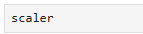

In [9]:
scaler

MinMaxScaler()

### The following function transforms the fibonacci sequence into training and test dataset.

X and Y looks like the following. From X and Y, we create training and test dataset.


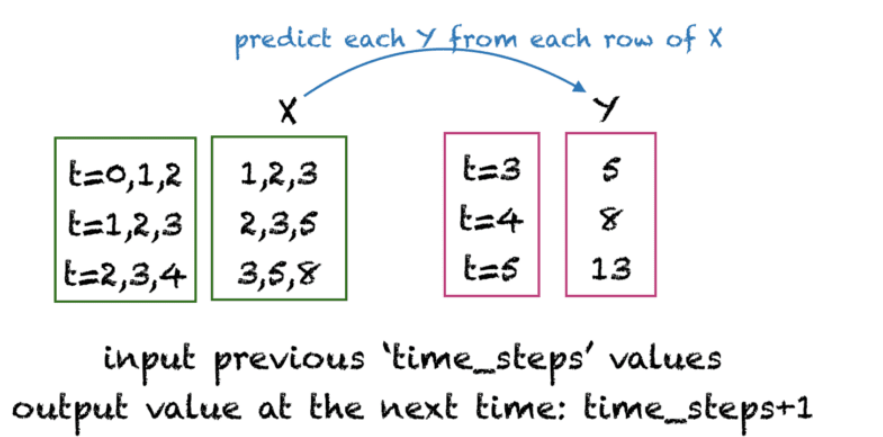

____________________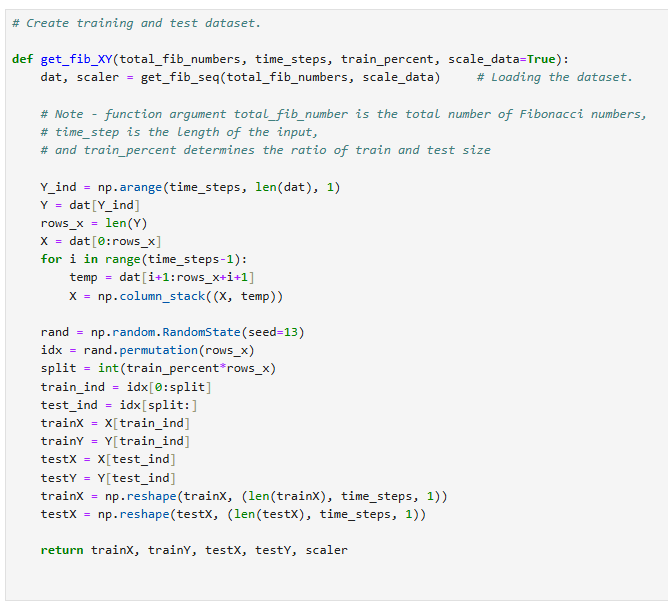

In [10]:
def get_fib_XY(total_fib_numbers, time_steps, train_percent, scale_data=True) :
    dat, scaler = get_fib_seq(total_fib_numbers, scale_data)
    
    Y_ind = np.arange(time_steps, len(dat), 1)
    Y = dat[Y_ind]
    rows_x = len(Y)
    X = dat[0:rows_x]
    for i in range(time_steps-1):
        temp = dat[i+1:rows_x+i+1]
        X = np.column_stack((X, temp))
        
    rand = np.random. RandomState(seed=13)
    idx = rand. permutation(rows_x)
    split = int(train_percent*rows_x)
    train_ind = idx[0:split]
    test_ind = idx[split:]
    trainX = X[train_ind]
    trainY = Y[train_ind]
    testX = X[test_ind]
    testY = Y[test_ind]
    trainX = np.reshape(trainX, (len(trainX), time_steps, 1))
    testX = np.reshape(testX, (len(testX), time_steps, 1))
    
    return trainX, trainY, testX, testY, scaler


_________________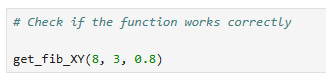

In [11]:
get_fib_XY(8, 3, 0.8)

(array([[[0.03030303],
         [0.06060606],
         [0.12121212]],
 
        [[0.12121212],
         [0.21212121],
         [0.36363636]],
 
        [[0.21212121],
         [0.36363636],
         [0.60606061]],
 
        [[0.        ],
         [0.03030303],
         [0.06060606]]]),
 array([0.21212121, 0.60606061, 1.        , 0.12121212]),
 array([[[0.06060606],
         [0.12121212],
         [0.21212121]]]),
 array([0.36363636]),
 MinMaxScaler())

In [12]:
#np.column_stack?

In [13]:
#np.random.RandomState.permutation?

### In the following code, we test the performance with the help of a simple RNN.


#### Set up parameters

__________________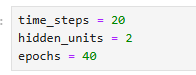

In [14]:
time_steps = 20
hidden_units = 2
epochs = 52

#### Create a traditional RNN network

______________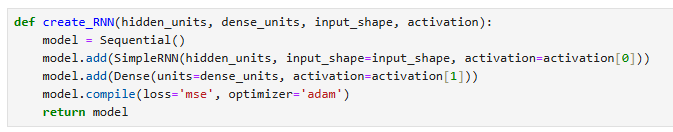

In [15]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mse', optimizer='adam')
    return model

___________________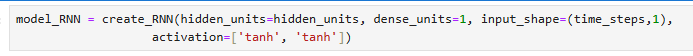

In [16]:
model_RNN = create_RNN(hidden_units=hidden_units, dense_units=1, input_shape=(time_steps,1), activation=['tanh', 'tanh' ])

C:\Users\Dhana\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


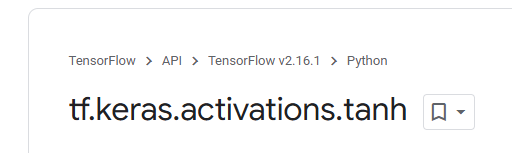
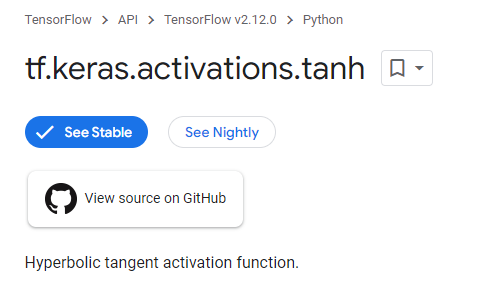

##### tf.keras.activations.tanh

https://www.tensorflow.org/api_docs/python/tf/keras/activations/tanh

In [17]:
# Your code to print the model summary

model_RNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 2)                   │               8 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11 (44.00 B)

 Trainable params: 11 (44.00 B)

 Non-trainable params: 0 (0.00 B)

________________________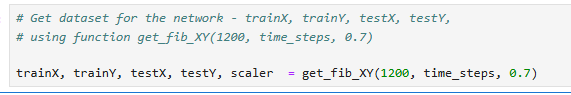

In [18]:
trainX, trainY, testX, testY, scaler = get_fib_XY(1200, time_steps, 0.7)

#### Train the network

_____________________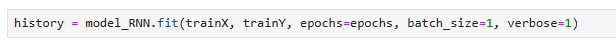

In [19]:
history = model_RNN.fit(trainX, trainY, epochs=epochs, batch_size=1, verbose=1)

Epoch 1/52
826/826 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011 
Epoch 2/52
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0014
Epoch 3/52
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0017
Epoch 4/52
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0042
Epoch 5/52
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.9268e-04
Epoch 6/52
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.2940e-04
Epoch 7/52
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0021
Epoch 8/52
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.3081e-04
Epoch 9/52
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.2483e-04
Epoch 10/52
826/826 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.0996e-04
Epoch 11/52
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.0187e-04
Epoch 12/52
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6405e-04
Epoch 13/52
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0029
Epoch 14/52
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.2112e-04
Epoch 15/52
826/826 ━━━━

____________________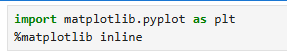

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

#### Hint:

You can copy blocks of code in the cells above and cells from previous weeks of practice sessions.

Some are easy enough to copy, some need to be slightly modified. This can speed up your code creation.

___________________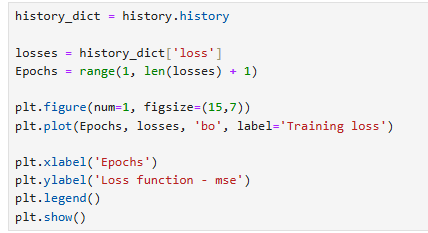

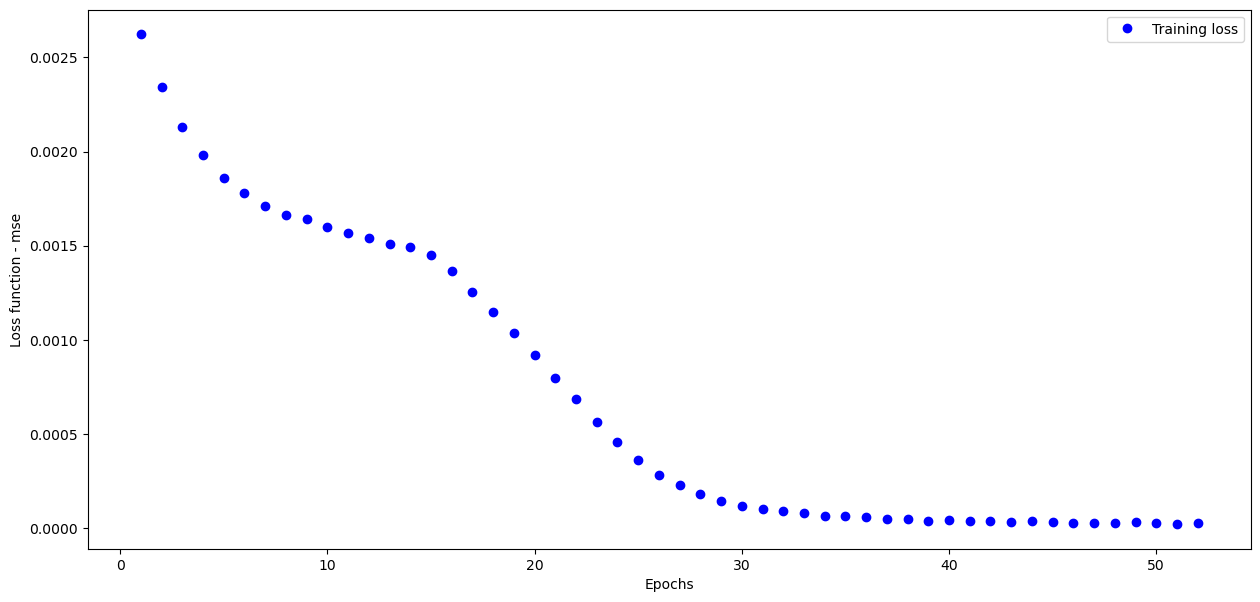

In [21]:
history_dict = history.history

losses = history_dict['loss']
Epochs = range(1, len(losses) + 1)

plt.figure(num=1, figsize=(15,7))
plt.plot(Epochs, losses, 'bo', label='Training loss')

plt.xlabel('Epochs')
plt.ylabel('Loss function - mse')
plt.legend()
plt.show()

#### Evalute model

____________________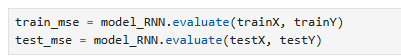

In [22]:
train_mse = model_RNN.evaluate(trainX, trainY)
test_mse = model_RNN.evaluate(testX, testY)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8326e-05  
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.3594e-06 


#### Print train and test error metrics

__________________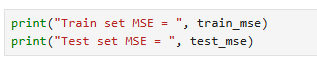

In [23]:
print("Train set MSE = ", train_mse)
print("Test set MSE = ", test_mse)

Train set MSE =  1.9648246961878613e-05
Test set MSE =  1.6974514437606558e-05


In [24]:
print("Train set MSE = ", train_mse)
print("Test set MSE = ", test_mse)

Train set MSE =  1.9648246961878613e-05
Test set MSE =  1.6974514437606558e-05


### The following code creates an attention layer. You need to understand each line to know how an attention layer can be created. 


_____________________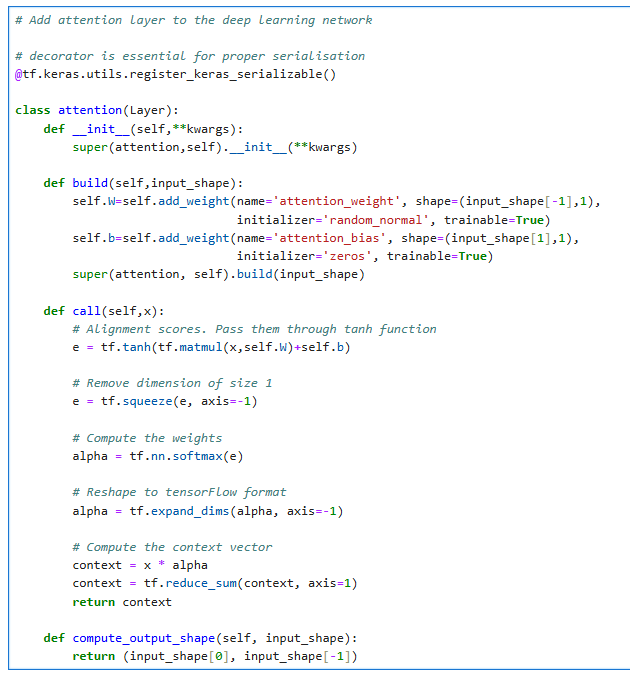

In [25]:
@tf.keras.utils.register_keras_serializable()

class attention(Layer) :
    def _init_(self, ** kwargs):
        super(attention, self) .__init__( ** kwargs)
    
    def build(self, input_shape):
        self. W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
        initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1], 1),
        initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)
    
    def call(self, x):
    
        e = tf. tanh(tf.matmul(x, self.W)+self.b)
        
        e = tf.squeeze(e, axis =- 1)
        
        alpha = tf.nn. softmax(e)
        
        alpha = tf.expand_dims(alpha, axis =- 1)
        
        context = x * alpha
        context = tf.reduce_sum(context, axis=1)
        return context
    
    def compute_output_shape(self, input_shape) :
        return (input_shape[0], input_shape[-1])

### The following code develops an RNN with an attention layer to predict the Fibonacci sequence.



________________________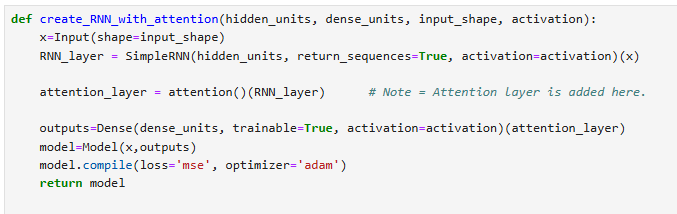

In [26]:
def create_RNN_with_attention(hidden_units, dense_units, input_shape, activation):
    x=Input(shape=input_shape)
    RNN_layer = SimpleRNN(hidden_units, return_sequences=True, activation=activation) (x)
    
    attention_layer = attention() (RNN_layer)
    
    outputs=Dense(dense_units, trainable=True, activation=activation)(attention_layer)
    model=Model(x, outputs)
    model.compile(loss='mse', optimizer='adam')
    return model

________________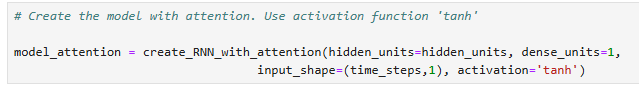

In [27]:
model_attention = create_RNN_with_attention(hidden_units=hidden_units, dense_units=1, input_shape=(time_steps,1), activation='tanh')

In [28]:
# Your code to print the model summary
model_attention.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 20, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 20, 2)               │               8 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention (attention)                │ (None, 2)                   │              22 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33 (132.00 B)

 Trainable params: 33 (132.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Your code to fit the model
# save the results of the training to 'history_2' variable list
# use batch_size=1

history_2 = model_attention.fit(trainX, trainY, epochs=epochs, batch_size=1, verbose=1)

Epoch 1/52
826/826 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.3092e-05
Epoch 2/52
826/826 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0020
Epoch 3/52
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.2833e-04
Epoch 4/52
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.0635e-04
Epoch 5/52
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.0107e-04
Epoch 6/52
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.3440e-04
Epoch 7/52
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1016e-04
Epoch 8/52
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.7149e-04
Epoch 9/52
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0789e-04
Epoch 10/52
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.9259e-04
Epoch 11/52
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.3321e-04
Epoch 12/52
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.3166e-04
Epoch 13/52
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.6881e-04
Epoch 14/52
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0548e-04
Epoch

#### Hint:

You can copy blocks of code in the cells above and cells from previous weeks of practice sessions.

Some are easy enough to copy, some need to be slightly modified. This can speed up your code creation.


_______________________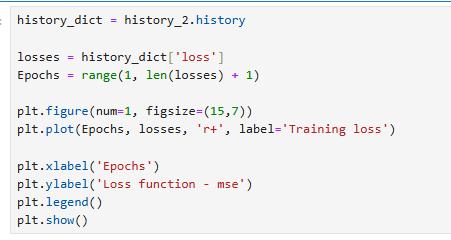

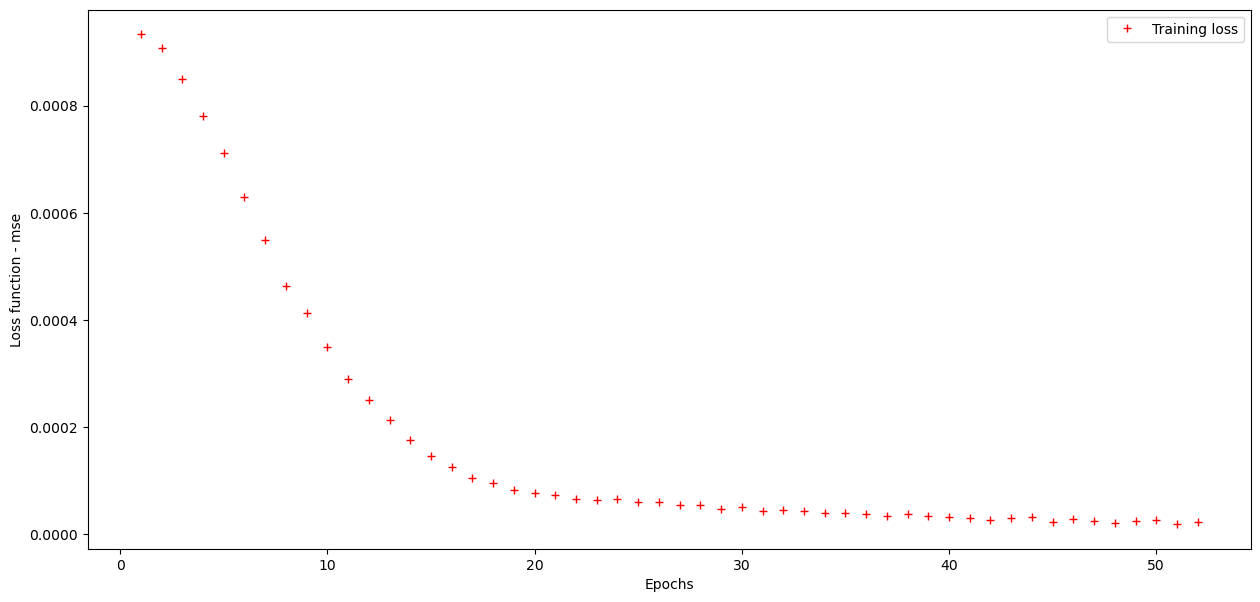

In [30]:
history_dict = history_2.history

losses = history_dict['loss']
Epochs = range(1, len(losses) + 1)

plt.figure(num=1, figsize=(15,7))
plt.plot(Epochs, losses, 'r+', label='Training loss')

plt.xlabel('Epochs')
plt.ylabel('Loss function - mse')
plt.legend()
plt.show()

In [31]:
# Your code to Evaluate attention model on training set
# Your code to evaluate the attention model on the test set
train_mse_attn = model_attention.evaluate(trainX, trainY)
test_mse_attn = model_attention.evaluate(testX, testY)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6011e-05 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2320e-05 


In [32]:
# Your code to print train error metric
# Your code to print test error metric
print("Train set MSE = ", train_mse_attn)
print("Test set MSE = ", test_mse_attn)

Train set MSE =  1.4947601812309586e-05
Test set MSE =  4.334808181738481e-05


In [33]:
# Draw both loss functions' graphs together

________________________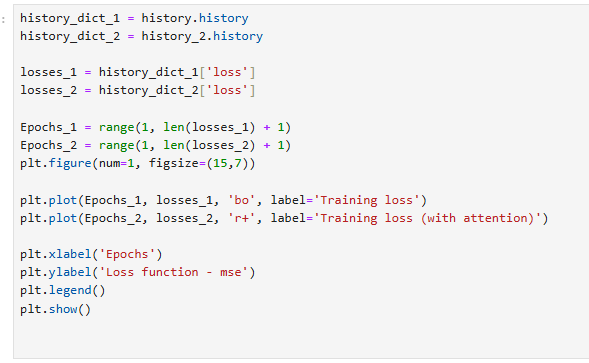

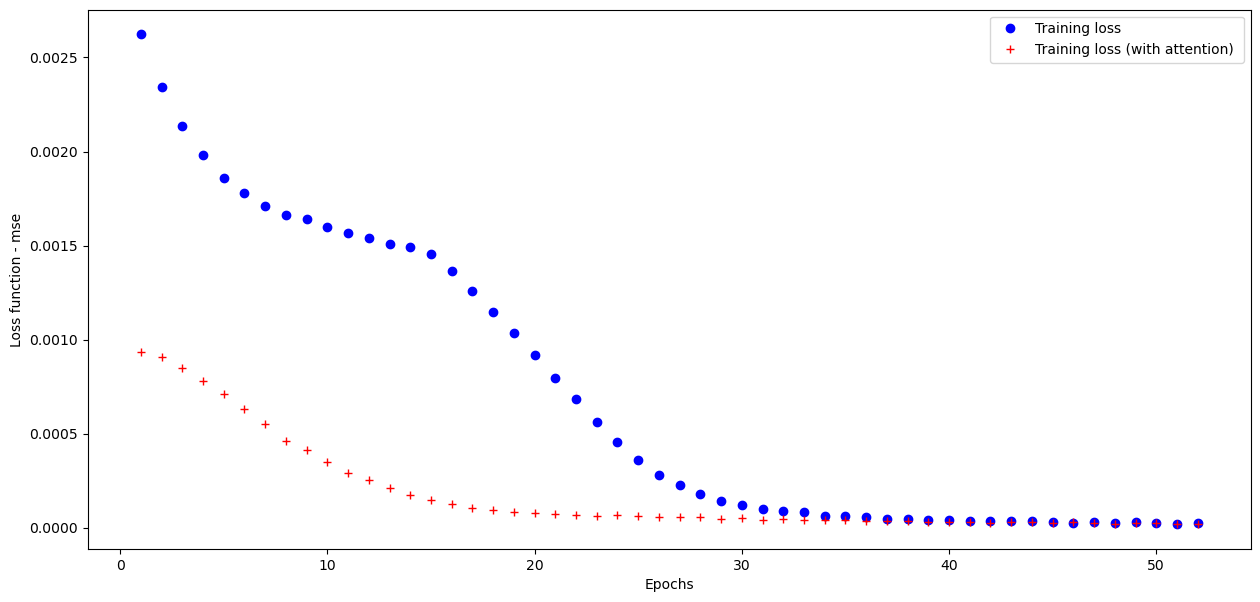

In [34]:
history_dict_1 = history.history
history_dict_2 = history_2.history

losses_1 = history_dict_1['loss' ]
losses_2 = history_dict_2[ 'loss' ]

Epochs_1 = range(1, len(losses_1) + 1)
Epochs_2 = range(1, len(losses_2) + 1)
plt.figure(num=1, figsize=(15,7))

plt.plot(Epochs_1, losses_1, 'bo', label='Training loss')
plt.plot(Epochs_2, losses_2, 'r+', label='Training loss (with attention) ')

plt.xlabel('Epochs')
plt.ylabel('Loss function - mse')
plt.legend()
plt.show()

### Plot the train and test MSE performance for the 'Simple RNN' and 'RNN with an attention layer'.


_________________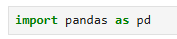

In [35]:
import pandas as pd

_______________________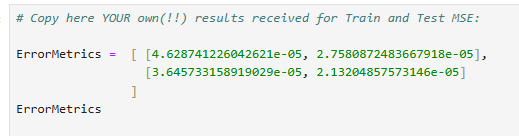

In [36]:
ErrorMetrics = [ [4.628741226042621e-05, 2.7580872483667918e-05],
[3.645733158919029e-05, 2.13204857573146e-05]
]
ErrorMetrics

[[4.628741226042621e-05, 2.7580872483667918e-05],
 [3.645733158919029e-05, 2.13204857573146e-05]]

____________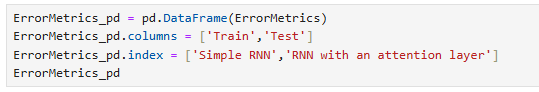

In [37]:
ErrorMetrics_pd = pd. DataFrame(ErrorMetrics)
ErrorMetrics_pd.columns = ['Train' , 'Test' ]
ErrorMetrics_pd.index = ['Simple RNN', 'RNN with an attention layer' ]
ErrorMetrics_pd

,Train,Test
Simple RNN,0.000046,0.000028
RNN with an attention layer,0.000036,0.000021


In [38]:
## MSE performance histogram

__________________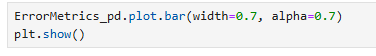

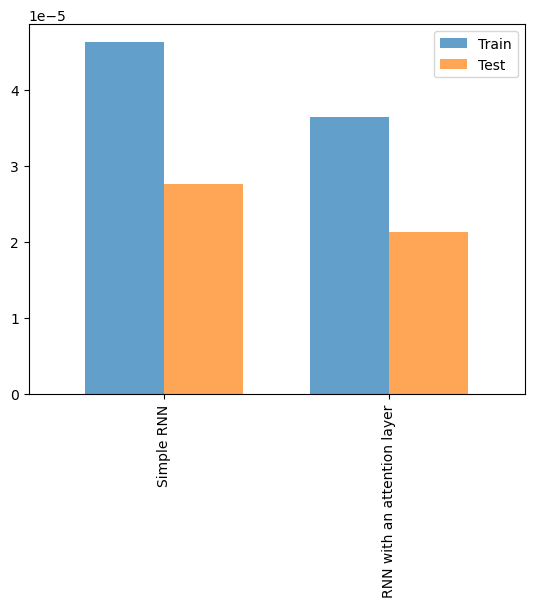

In [39]:
ErrorMetrics_pd.plot.bar(width=0.7, alpha=0.7)
plt.show()

# Lab Logbook Requirement:

<html> <h3 style="; color:blue;">

1) Modify the training parameter of the RNN with an attention layer model using the following formulas:

Modify the number of epochs:
Z + 50
, where your SID is: XXXXXXZ

Use EarlyStopping() and ModelCheckpoint() function to save the best modetl in the file 'best_attention_model.keras' 
Modify the patience parameter:
Z + 10
, where your SID is: XXXXXXZ

2) Modify time_steps = 20 and hidden_units = 4
3) Leave other parameters the same as in the practical session
4) Calculate and demonstrate the received loss for train and test datasets
5) Plot the Loss function (MSE) graph during the training process for the 3 models together
6) Please only add to your Lab Logbook print-screens of:
- calculation of your parameters
- your code of using EarlyStopping() and ModelCheckpoint() functions
- your code and training result using model.fit()
- received loss for train and test datasets
- Loss (MSE) graph for the 3 models together during the training process
- performance histogram for train and test loss (MSE) of the 3 models together


</h3> </html>


<html> <h3 style="color:red;">
NOTE: DON'T FORGET TO SAVE AND BACK UP YOUR COMPLETED JUPYTER NOTEBOOK AND LAB LOGBOOK ON GITHUB OR ONEDRIVE.
</h3> </html>

### Test the above model with different parameters, layer size, train and test ratio, and time steps.



__________________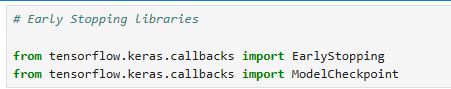

In [40]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

________________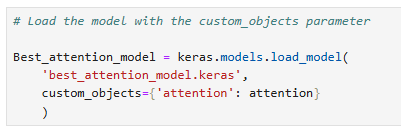

In [41]:
Best_attention_model = model_attention

In [42]:
Best_attention_model = keras.models.load_model('best_model_LSTM_Silver_3D_Tensor.keras', custom_objects={'attention':attention})

In [43]:
# Your code of parameter modification

time_steps = 20

hidden_units = 4

epochs = 40

patience = 18

In [44]:
# Continue your code according to the Lab Logbook Requirements ...
history_3 = Best_attention_model.fit(trainX, trainY, epochs=epochs, batch_size=1, verbose=1)

Epoch 1/40


ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 1 and 18 for '{{node sequential_1/lstm_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_1/lstm_1/strided_slice_1, sequential_1/lstm_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [1,1], [18,396].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(1, 1), dtype=float32)
  • states=('tf.Tensor(shape=(1, 99), dtype=float32)', 'tf.Tensor(shape=(1, 99), dtype=float32)')
  • training=True

In [45]:
history_dict = history_3.history

losses = history_dict['loss']
Epochs = range(1, len(losses) + 1)

plt.figure(num=1, figsize=(15,7))
plt.plot(Epochs, losses, 'b+', label='Training loss')

plt.xlabel('Epochs')
plt.ylabel('Loss function - mse')
plt.legend()
plt.show()

NameError: name 'history_3' is not defined

In [46]:
history_dict_1 = history.history
history_dict_3 = history_3.history

losses_1 = history_dict_1['loss' ]
losses_2 = history_dict_3[ 'loss' ]

Epochs_1 = range(1, len(losses_1) + 1)
Epochs_2 = range(1, len(losses_2) + 1)
plt.figure(num=1, figsize=(15,7))

plt.plot(Epochs_1, losses_1, 'bo', label='Training loss')
plt.plot(Epochs_2, losses_2, 'r+', label='Training loss (with attention) ')

plt.xlabel('Epochs')
plt.ylabel('Loss function - mse')
plt.legend()
plt.show()

NameError: name 'history_3' is not defined

In [47]:
train_mse_attn = model_attention.evaluate(trainX, trainY)
test_mse_attn = model_attention.evaluate(testX, testY)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6011e-05
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2320e-05 
